In [ ]:
import numpy as np


In [ ]:

!pip install gym-retro
import retro
env = retro.make(game='Airstriker-Genesis')

In [ ]:
shape=env.observation_space.shape
state_size=shape[0]*shape[1]*shape[2]
state_size
print('state shape:',shape)


state shape: (224, 320, 3)


In [ ]:
print(env.action_space.sample())

[0 0 0 0 1 1 1 0 1 0 0 0]


In [ ]:
def hot_encode_action( action):
    '''encoding the actions into a binary list'''

    action_encoded=np.zeros(12, np.float32)
    action_encoded[action]=1

    return action_encoded

In [ ]:
nbActions=env.action_space.n
print('num actions:',nbActions)

num actions: 12


In [ ]:


def epsGreedy(mymodel, state, epsilon):
  if np.random.rand() <= epsilon:
    # explore
     #return hot_encode_action(np.random.randint(0,high=nbActions))
     return env.action_space.sample()
  else:
    #exploite
    state=np.array(state)
    #print('from epsGreedy',state)
    q_values=my_model(state.reshape(1,state.shape[0],state.shape[1],state.shape[2],1))#Q_old
    #return  env.action_space.sample()
    return hot_encode_action(np.argmax(q_values[0]))
    
#input_data.reshape((input_data.shape[0],input_data.shape[1],input_data.shape[2],1)).shape[1:]

In [ ]:
def epsGreedy2(state, epsilon):
  # explore
  a=np.random.randint(0,high=nbActions)
  a=hot_encode_action(a)
  return  env.action_space.sample()
 

In [ ]:
D=[]
A_t=[]
D_t_p=[]
A_t_p=[]
V_t=[]
dones=[]

In [ ]:
def Memory_filling(nbr_episodes,alpha,epsilon,gamma):
  nbActions = env.action_space.n
  numActions = env.action_space
  episodeLength=[]
  episodeReward=[]
  #let's learn
  for it in range(nbr_episodes):#Répéter éternellement pour chaque épisode
    s1 = env.reset()
    w=np.array([0])
    a1 = epsGreedy2(s1, epsilon)#on choisit une action avec epsilon-greedy
    done=False
    rt=0
    el=0
    while (not done):#Répète pour chaque étape de l'épisode
      s2, r, done, info = env.step(a1)
      #s2 = encode(obs, tilings)
      a2 = epsGreedy2( s2, epsilon)
      s1_temp=s1
      a1_temp=a1
      s1 = s2
      a1 = a2#la nouvelle action devient l'ancienne 
      el += 1
      rt += r
      transition=[s1,a1_temp,r,s2,done]
      D.append(s1_temp)
      A_t.append(a1_temp)
      A_t_p.append(a1)
      D_t_p.append(s1)
      V_t.append(r)
      dones.append(done)
      
    episodeLength.append(el)
    episodeReward.append(rt)
  return w, episodeLength, episodeReward,np.array(D),np.array(A_t),np.array(V_t),np.array(D_t_p),np.array(A_t_p),np.array(dones)


In [ ]:
  w_test,episodeLength_test,episodeReward_test,my_memory_test,policies_test,values_test,my_memory_test_p,policies_test_p,dones_p=Memory_filling(2,0.01,0.1,0.99)

In [ ]:
import tensorflow as tf
from keras import backend as K
from keras.optimizers import Adam


def huber_loss(y_true, y_pred, clip_delta=1.0):
      error = y_true - y_pred
      print(error)
      cond  = K.abs(error) <= clip_delta

      squared_loss = 0.5 * K.square(error)
      quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)

      return K.mean(tf.where(cond, squared_loss, quadratic_loss))

In [ ]:
def resize(state):
      return cv2.resize(state,(32,32))

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
from tensorflow.keras import layers 
from tensorflow.keras import regularizers

nb_actions = env.action_space.n
epochs = 200
batch = 20
#*****
alpha=0.01
epsilon=0.8
gamma=0.90
filters=3

learning_rate=0.001

def NN_qlearning(input_data):
  N =input_data.shape[0]
  input_data = input_data.astype ('float32')
  value = np.random.randint(2, size=(batch,))#gagné ou perdu
  value = value.astype ('float32')
  #print(input_data.shape)
  #input = keras.Input(shape=input_data.reshape((input_data.shape[0],input_data.shape[1],input_data.shape[2],input_data.shape[3],1)).shape[1:],batch_size=batch, name='data')
  input=keras.Input(shape=(32,32,3))
  for i in range (4):#pour model résiduel
      x = layers.ReLU()(input)
      x=layers.Dropout(0.10)(x)
      x = layers.BatchNormalization()(x)

  
  value_head = layers.Dense(30, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
  value_head=layers.Dropout(0.10)(value_head)
  value_head = layers.Flatten()(value_head)
  value_head = layers.Dense(nb_actions, activation='linear', name='value', kernel_regularizer=regularizers.l2(0.0008))(value_head)

  model = keras.Model(inputs=input, outputs= value_head)
  model.summary ()

  model.compile(loss=huber_loss,
                      optimizer=Adam(lr=learning_rate))
  
  
  return model





In [ ]:
my_model= NN_qlearning(my_memory_test)
target_model=NN_qlearning(my_memory_test)




Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
re_lu_115 (ReLU)             (None, 32, 32, 3)         0         
_________________________________________________________________
dropout_143 (Dropout)        (None, 32, 32, 3)         0         
_________________________________________________________________
batch_normalization_115 (Bat (None, 32, 32, 3)         12        
_________________________________________________________________
dense_28 (Dense)             (None, 32, 32, 30)        120       
_________________________________________________________________
dropout_144 (Dropout)        (None, 32, 32, 30)        0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 30720)             0  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
re_lu_119 (ReLU)             (None, 32, 32, 3)         0         
_________________________________________________________________
dropout_148 (Dropout)        (None, 32, 32, 3)         0         
_________________________________________________________________
batch_normalization_119 (Bat (None, 32, 32, 3)         12        
_________________________________________________________________
dense_29 (Dense)             (None, 32, 32, 30)        120       
_________________________________________________________________
dropout_149 (Dropout)        (None, 32, 32, 30)        0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 30720)             0  

In [ ]:

def add_to_memory(s1_temp,a1_temp,r,s1,done):
  D.append(s1_temp)
  A_t.append(a1_temp)
  D_t_p.append(s1)
  V_t.append(r)
  dones.append(done)



In [ ]:
def pick_random_transition(batch_size):

  indice = np.random.choice(len(D), batch_size, replace=False)#on tire un indice aléatoire 
  transition_aleatoire=[]
  policies=[]
  values=[]
  policies_p=[]
  transition_aleatoire_p=[]
  dones_rand=[]

  for idx in range(len(indice)):
    transition_aleatoire.append(D[indice[idx]])
    policies.append(A_t[indice[idx]])
    values.append(V_t[indice[idx]])
    transition_aleatoire_p.append(D_t_p[indice[idx]])
    dones_rand.append(dones[indice[idx]])


  return np.array(transition_aleatoire),np.array(policies),np.array(values),np.array(transition_aleatoire_p),np.array(dones_rand)


In [ ]:
def replay(my_model,target_model,batch_size,epsilon):
      state,policies,value,new_state,done=pick_random_transition(1)#tirer des transitions aléatoires (ici 1 seule)
      state=state[0, :, :]
      shape=state.shape
      new_state=new_state[0, :, :]
      new_state=resize(new_state)
      new_state=new_state.reshape(1,new_state.shape[0],new_state.shape[1],new_state.shape[2])
      value = value.astype('float32')#Calcuker
      state=resize(state)
      shape=state.shape
      state=state.reshape(1,shape[0],shape[1],shape[2])
      target=my_model(state)#Q_old, OK

      #print(target.shape)
      #si c'est terminé, mon réseau a la bonne réponse pas besoin d'apprendre
      if  done:
        target.numpy()[0][policies]=value#OK
        #print(rt,epsilon)
        

      else:
        #print(position_p.shape)
        #print(policies.shape)
        target.numpy()[0][np.argmax(policies,axis=1)]=value+gamma*np.amax(target_model(new_state)[0]) #target.numpy()[0] is to convert the tensor  into  a nimpy array   #OK
        target=tf.convert_to_tensor(target)#we convert it back into a tensor
        if(epsilon>epsilon_min):
          epsilon -= reduction #decay epsilon  
        #env.render()
        history = my_model.fit(state,#Optimisation de l'erreur moyenne
                              { 'value': target}, 
                              epochs=1, batch_size=batch,verbose=2)


In [ ]:
def target_train(my_model,target_model):
  weight=my_model.get_weights()
  target_weights=target_model.get_weights()
  for i in range(len(target_weights)):
    target_weights[i] = weights[i]
    self.target_model.set_weights(target_weights)


In [ ]:
NBR_MAX_ITERATIONS=600
epsilon_min=0.01
epsilon=0.99
nbr_episodes=20
reduction =(epsilon)/nbr_episodes

def deep_qn(my_model,my_target_model,nbr_episodes,alpha,epsilon,gamma):
  nbActions = env.action_space.n
  numActions = env.action_space
  episodeLength=[]
  episodeReward=[]
  rewards=[]
  length_table=[]
  rt=0

  #let's learn
  for episode in range(nbr_episodes):#Répéter éternellement pour chaque épisode
    current_state = resize(env.reset())
    a1 = epsGreedy(my_model, current_state, epsilon)#on choisit une action avec epsilon-greedy
    episodeReward.append(rt)
    episodeLength.append(episode)
    done=False
    rt=0
    el=0
    length=0
    for it in range(NBR_MAX_ITERATIONS):
      a1 = epsGreedy(my_model, current_state, epsilon)#on choisit une action avec epsilon-greedy
      new_state, r, done, _ = env.step(a1)     
      length=length+1
       # updates
      a1_temp=a1
      el += 1
      rt += r
      print(r)
      add_to_memory(resize(current_state),a1_temp,r,resize(new_state),done)#Ajouter dans la mémoire 
      #ça c'est la partie replay
      replay(my_model,target_model,1,epsilon)
      target_model.set_weights(my_model.get_weights())#update the target network
      curent_state=new_state
      if done:
        print('done')
       
        break
      
       
      '''
      if it >= 199:
          print("Failed to complete in trial {}".format(episode))
          if it % 10 == 0:
              my_model.save("trial-{}.model".format(episode))
      else:
          print("Completed in {} trials".format(episode))
          my_model.save("success.model")
          break
      '''
  env.close()
  return episodeReward,episodeLength
        
        
      
      
      #target_value is the label here 

In [ ]:
!apt-get install python-opengl -y

!apt install xvfb -y

!pip install pyvirtualdisplay

!pip install piglet


from pyvirtualdisplay import Display
Display().start()

import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
import cv2
#f I understand it correctly, the old SEGA controller has 12 buttons ('B', 'A', 'MODE', 'START', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'C', 'Y', 'X', 'Z')
e1,e2=deep_qn(my_model,target_model,20,0.01,0.99,0.90)

In [ ]:
my_model.save("success.model")


INFO:tensorflow:Assets written to: success.model/assets


INFO:tensorflow:Assets written to: success.model/assets


In [ ]:
print(e1) 
print(e2)

[0, 60.0, 60.0, 40.0, 80.0, 80.0, 40.0, 100.0, 60.0, 20.0, 100.0, 60.0, 60.0, 60.0, 80.0, 60.0, 60.0, 40.0, 80.0, 80.0]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


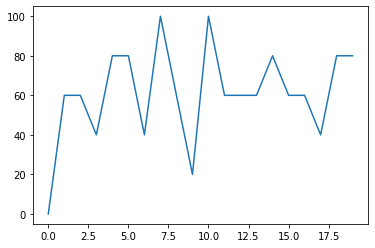

In [ ]:
plt.plot(e2,e1)